## Basic Model


Let's create a basic CNN model and try to familiarize ourselves with the dataset.

In [32]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
import pandas as pd
from fastai.metrics import error_rate
import librosa
import librosa.display
from EasyDict import EasyDict
import IPython
import IPython.display
from tqdm import tqdm_notebook
from PIL import Image as pilImage
import os
import sklearn.metrics

In [51]:
DATA = Path('data')
CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'
TRN_CURATED = DATA/'train_curated'
TRN_NOISY = DATA/'train_noisy'
TEST = DATA/'test'

WORK = Path('work')
IMG_TRN_CURATED = WORK/'image/trn_curated'
IMG_TRN_NOISY = WORK/'image/trn_noisy'
IMG_TEST = WORK/'image/test'
for folder in [WORK, IMG_TRN_CURATED, IMG_TRN_NOISY, IMG_TEST]: 
    Path(folder).mkdir(exist_ok=True, parents=True)

train_df = pd.read_csv(CSV_TRN_CURATED)
train_noisy_df = pd.read_csv(CSV_TRN_NOISY)
test_df = pd.read_csv(CSV_SUBMISSION)

## Convert Audio to Spectrograms


So it seems like everyone is turning this audio classification class into an image classification task in which we look at visual representations of the sounds.

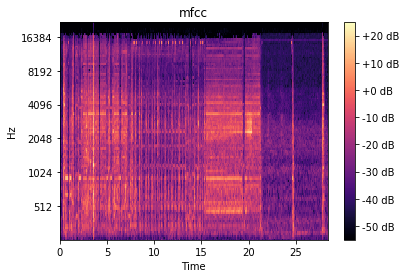

In [7]:
def read_audio(conf, pathname, trim_long_data):
    y, _ = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y


def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def show_melspectrogram(conf, mels, title='mfcc'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

    
def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels


conf = EasyDict()
conf.sampling_rate = 44100
conf.duration = 2
conf.hop_length = 347 # to make time steps 128
conf.fmin = 20
conf.fmax = conf.sampling_rate // 2
conf.n_mels = 128
conf.n_fft = conf.n_mels * 20

conf.samples = conf.sampling_rate * conf.duration

# example
x = read_as_melspectrogram(conf, TRN_CURATED/'0b8ec4ea.wav', trim_long_data=False, debug_display=True)

In [8]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def convert_wav_to_image(df, source, img_dest):
    
    #Check whether the files already exist in the destination folder
    filename = str(df.iloc[0].fname) + ".jpg"
    if os.path.isfile(img_dest/filename):
        print("First image already exists. Skipping")
        return
    
    for i, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram(conf, source/str(row.fname), trim_long_data=False)
        x_color = mono_to_color(x)
        img = pilImage.fromarray(x_color)
        filename = str(row.fname) + ".jpg"
        img.save(img_dest/filename)
        
%time convert_wav_to_image(train_df, source=TRN_CURATED, img_dest=IMG_TRN_CURATED)
%time convert_wav_to_image(train_noisy_df, source=TRN_NOISY, img_dest=IMG_TRN_NOISY)
%time convert_wav_to_image(test_df, source=TEST, img_dest=IMG_TEST)

CPU times: user 13min 27s, sys: 2.05 s, total: 13min 29s
Wall time: 3min 22s


CPU times: user 1h 35min 57s, sys: 10.7 s, total: 1h 36min 8s
Wall time: 24min 3s


CPU times: user 3min 45s, sys: 560 ms, total: 3min 46s
Wall time: 56.6 s


In [11]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)
src = (ImageList.from_csv(WORK/'image', Path('../../')/CSV_TRN_CURATED, folder='trn_curated', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=',')
)

data = (src.transform(tfms, size=128)
        .databunch(bs=64).normalize(imagenet_stats)
)

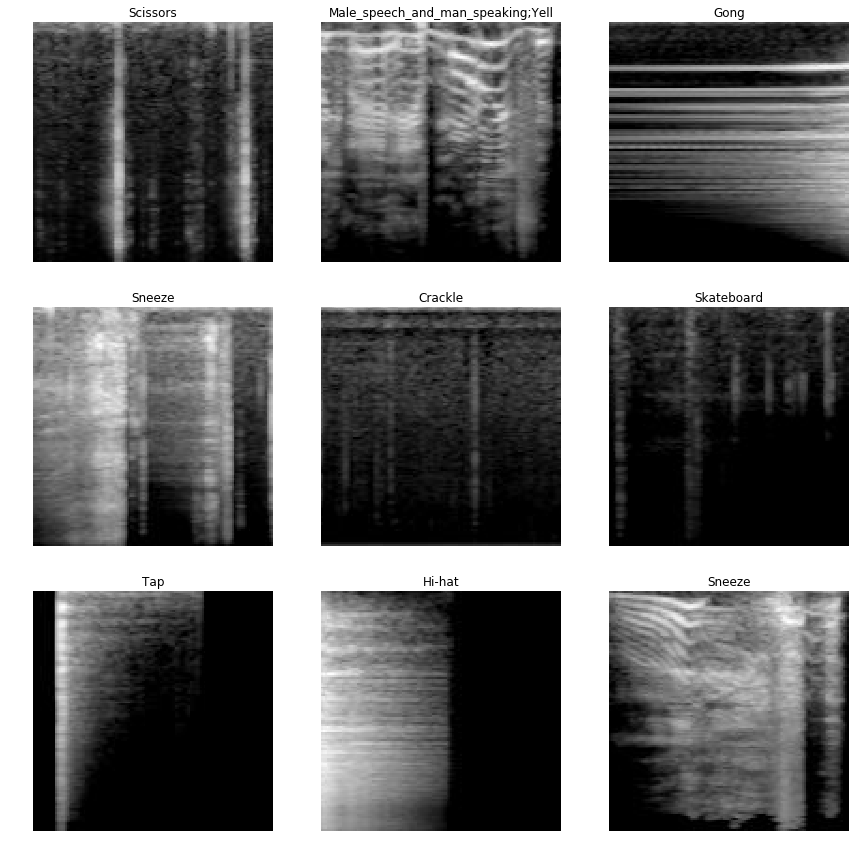

In [12]:
data.show_batch(3)

In [72]:
def calculate_overall_lwlrap_sklearn(scores, truth):
    # Calculate the overall lwlrap using sklearn.metrics.lrap.
    # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
    
    overall_lwlrap = sklearn.metrics.label_ranking_average_precision_score(truth > 0, scores)
    
    return torch.Tensor([overall_lwlrap])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


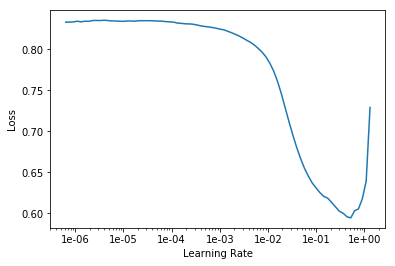

In [73]:
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[f_score, calculate_overall_lwlrap_sklearn])
#learn.unfreeze()


learn.lr_find()
learn.recorder.plot()

In [74]:
learn.fit_one_cycle(5, slice(1e-6, 1e-1))

epoch,train_loss,valid_loss,fbeta,calculate_overall_lwlrap_sklearn,time
0,0.203899,0.083833,0.018514,0.108953,00:12
1,0.105907,0.094341,0.042144,0.127482,00:12
2,0.083179,0.091654,0.043204,0.221716,00:12
3,0.073773,0.060867,0.060676,0.294698,00:12
4,0.066953,0.059143,0.054823,0.326234,00:13


In [75]:
learn.unfreeze()
learn.fit_one_cycle(100, slice(1e-6, 1e-1))

epoch,train_loss,valid_loss,fbeta,calculate_overall_lwlrap_sklearn,time
0,0.063101,0.063375,0.076185,0.349435,00:13
1,0.061701,0.061401,0.100791,0.349000,00:12
2,0.060690,0.086717,0.123054,0.372864,00:12
3,0.060151,0.106957,0.096954,0.372456,00:12
4,0.059773,0.062954,0.137580,0.403046,00:12
5,0.058849,0.090769,0.147184,0.411198,00:13
6,0.058172,0.120083,0.227866,0.415861,00:12
7,0.058307,0.630947,0.192027,0.409058,00:12
8,0.057880,0.062195,0.227989,0.412588,00:12
9,0.058627,0.085213,0.124811,0.373222,00:12


In [27]:
learn.export()

In [29]:
test = ImageList.from_csv(WORK/'image', Path('../..')/CSV_SUBMISSION, folder='test', suffix='.jpg')
learn = load_learner(WORK/'image', test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [30]:
test_df[learn.data.classes] = preds
test_df.to_csv('submission.csv', index=False)